# Writing Flow Nodes

```{admonition} Prerequisites

* [You have installed Flow](installing)
```

In this guide you will learn how to define and use your own flow nodes. We will
touch on constructing a flow graph, for the simple reason that you need to know
how to apply the nodes you define yourself, but otherwise leave the topic of
constructing flow graphs to the guide ["specifying graphs"](specifying-graphs).

Defining nodes is done with the `lang` module. The module responsible for the
language that describes flow nodes and flow graphs. We need two components from
this module:

* {py:func}`node <flow.lang.definition.node>`: a decorator that creates flow
  nodes for Python objects.
* {py:func}`Namespace <flow.lang.definition.Namespace>`: the class where, by
  default, all flow nodes will be defined. Don't worry, this will become clear
  below.

We import these component as follows:

In [1]:
from flow.lang import node, Namespace

## Functions

One of the simplest ways to define a Flow node is with a function:

In [2]:
@node
def offset(value, *, delta):
    return value+delta

This will add a function `offset` to the class `Namespace`, but otherwise leave
the decorated function intact. You can still call it as you normally would:

In [3]:
print(offset(40, delta=2))

42


There now is a method `Namespace.offset` which is a *node constructor*. Calling
this method, in the appropriate context, will create a node to which values can
be streamed, and which will output those values with an offset.

## Generators

Generators can also be turned into Flow nodes, and are particularly well suited a *source* nodes. These are nodes that only have ouputs, where they generate data.

In [4]:
@node
def source():
    for i in range(10):
        yield i

The node created from this generator is self-activated, it will output a stream of
10 values and stop.

## Data classes

So far nodes have had single outputs. Even if a function would return a tuple,
it would be considered a single output. What if we want to create a node that
has multiple outputs?

For this we can use a `dataclass` which we must import from
[dataclasses](https://docs.python.org/3/library/dataclasses.html).

In [5]:
from dataclasses import dataclass

A dataclass is a convient construct created in Python 3 for the construction of
classes that, mostly, just contain data fields. When we turn it into a node, by
add the `@node` decorator like we did in the previous section, we create a node
with one output for each field in the dataclass.

In [6]:
@node
@dataclass
class DivMod:
    quotient: int
    remainder: int

    def __init__(self, a, b):
        self.quotient, self.remainder = divmod(a,b)

This will add `DivMod` as a node constructor to the `Namespace` class. It will
need two inputs, and it will, simultaneously, produce two outputs. 

## Stateful nodes

It is also possible to create nodes with *state*. The output of such nodes does
not solely depend on the inputs, but also on the internal state. Nodes like this
can be defined using a class that is derived from {py:func}`Firable <flow.lang.helpers.Firable>`:

In [7]:
from flow.lang import Firable

@node
class accumulate(Firable):
    def __init__(self, *, start=1):
        self.start = start

    def fire(self, a) -> int:
        self.start += a
        return self.start

Firable nodes must have a method called `fire`. This method is responsible for
computing new output values given the latest input values and state, and for
updating the state.

## The nodes in action

We can execute the nodes we have just created by constructing a *flow graph* and
giving that to a *processor*. But before we do this, we need to create one more
node. We need the data to go somewhere. It needs to have an endpoint. We need to
define a *sink*, a node with only inputs.

In [8]:
@node
def sink(v, w):
    print(v, w)

The `sink` definition should be familiar. The only difference with `offset` is
that it does not return a value, and hence will not create a node that has an
output.

With that done, we can construct if we import one more component from the `lang`
module:

* {py:func}`graph <flow.lang.composition.graph>`: a context manager that should be used when creating flow graphs.

Giving us:

In [9]:
from flow.lang import graph

with graph() as g:
    s1 = Namespace.source() 
    dm = Namespace.DivMod(Namespace.accumulate(s1), Namespace.offset(s1, delta=4))
    dm >> Namespace.sink().view(v="quotient", w="remainder")

The `>>` notation is another part of the flow language, and is described in more
detail in [this guide](specifying-graphs). For this guide you should understand
that it specifies streaming from left to right. In this case *source* has a
single output which will stream to the single input of *accumulate* and
*offset*. *accumulate* has a single output which will stream to the first input
of *DivMod*, and *offset* has a single output which will stream to the second
input of *DivMod*. *DivMod* has two outputs which will both be streamed to
*sink*.

Drawing the graph in a notebook is as simple as follows:

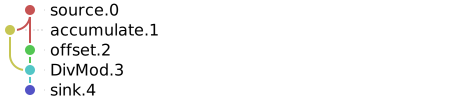

In [10]:
g

We can create an example trace of the execution in a sequence diagram (in this
case for a range of 3 integers):

| source   | c1      | offset   |  c2       |accumulate| c3      | c4      | divmod   | c5      | c6      | sink     |
|:--------:|:-------:|:--------:|:---------:|:--------:|:-------:|:-------:|:--------:|:-------:|:-------:|:--------:|
| **fire** | **0**   |          | **0**     |          |         |         |          |         |         |          |
| **fire** | **1**,0 |          | **1**,0   |          |         |         |          |         |         |          |
| **fire** | **2**,1 | **fire** | **2**,1,0 |          | **4**   |         |          |         |         |          |
|          | 2,1     |          | 2,1       | **fire** | 4       | **1**   |          |         |         |          |
|          | 2,1     |          | 2,1       |          |         |         | **fire** | **0**   | **1**   |          |
|          | 2       | **fire** | 2,1       |          | **5**   |         |          | 0       | 1       |          |
|          | 2       |          | 2         | **fire** | 5       | **2**   |          | 0       | 1       |          |
|          |         | **fire** | 2         |          | **6**,5 | 2       |          | 0       | 1       |          |
|          |         |          |           | **fire** | 6,5     | **4**,2 |          | 0       | 1       |          |
|          |         |          |           |          | 6       | 4       | **fire** | **0**   | **2**   | **fire** |
|          |         |          |           |          |         |         | **fire** | **0**,0 | **4**,2 |          |
|          |         |          |           |          |         |         |          | 0       | 4       | **fire** |
|          |         |          |           |          |         |         |          |         |         | **fire** |


This table shows the behavior of the nodes and channels during execution. The
nodes consume input values from channels and produce output values to channels.
The channels are FIFO's, meaning the order in which values are put into it by
the producer is the same as the order in which the consumer will take them out
again.

To execute this flow graph we need a processor. The simplest processor is the
*offline* processor, which can be used as follows:

In [11]:
from flow.processor.offline import OfflineProcessor

OfflineProcessor().execute(g)

0 1
0 2
0 4
1 0
1 3
1 7
2 2
2 7
3 1
3 7
